In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path as pt
from loguru import logger
from typing import TypedDict, Literal, Optional, List, Dict, Union, Tuple
import json
from sklearn.model_selection import learning_curve


In [18]:
root_loc = pt('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/')
base_loc = root_loc / 'ML properties/Analysed/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/'
main_loc = base_loc / 'tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data/'

model = 'lgbm'
embeddings = 'mol2vec_embeddings'
method = 'default'
pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
loc = main_loc / f'pretrained_models/{model}/{embeddings}/'
if method != 'normal':
    loc = loc / method

resultsfile = loc / f'{pre_trained_filename}.results.json'
datfile = loc / f'{pre_trained_filename}.dat.json'
learning_curve_file = loc / f'{pre_trained_filename}.learning_curve.json'
print(f'resultsfile exists: {resultsfile.exists()}')
print(f'datfile exists: {datfile.exists()}')
print(f'learning_curve_file exists: {learning_curve_file.exists()}')

resultsfile exists: True
datfile exists: True
learning_curve_file exists: True


In [4]:
# Define the structure of the inner dictionaries
class DataEntry(TypedDict):
    y_true: List[float]
    y_pred: List[float]
    y_linear_fit: List[float]
    
class DataType(TypedDict):
    test: DataEntry
    train: DataEntry


# Define the Embedding type
Embedding = Literal['mol2vec', 'VICGAE']

# Define the MLStats TypedDict
class MLStats(TypedDict):
    r2: float
    mse: float
    rmse: float
    mae: float

# Define the CVScores TypedDict
class CVScores(TypedDict):
    mean: float
    std: float
    ci_lower: float
    ci_upper: float
    scores: List[float]

# Define the CV_scoring_methods type
CV_scoring_methods = Literal['r2', 'mse', 'rmse', 'mae']

# Define the CVScoresData type
CVScoresData = Dict[Literal['test', 'train'], Dict[CV_scoring_methods, CVScores]]

# Define the PlotData and Layout TypedDicts (assuming simplified structures)
class PlotData(TypedDict, total=False):
    x: List[float]
    y: List[float]
    type: str
    name: str

class Layout(TypedDict, total=False):
    title: str
    xaxis: Dict[str, Union[str, int, float]]
    yaxis: Dict[str, Union[str, int, float]]

# Define the MLResults TypedDict
class MLResults(TypedDict):
    learning_curve_plotly_data: Optional[Dict[str, Union[List[PlotData], Layout]]]
    embedding: Embedding
    PCA: bool
    data_shapes: Dict[str, List[int]]
    train_stats: MLStats
    test_stats: MLStats
    model: str
    bootstrap: bool
    bootstrap_nsamples: Optional[int]
    cross_validation: bool
    cv_fold: Optional[int]
    cv_scores: Optional[CVScoresData]
    best_params: Optional[Dict[str, Union[str, int, bool, None]]]
    best_score: Optional[float]
    timestamp: str
    time: str
    

In [5]:
results: MLResults = json.load(open(resultsfile, 'r'))
data: DataType = json.load(open(datfile, 'r'))

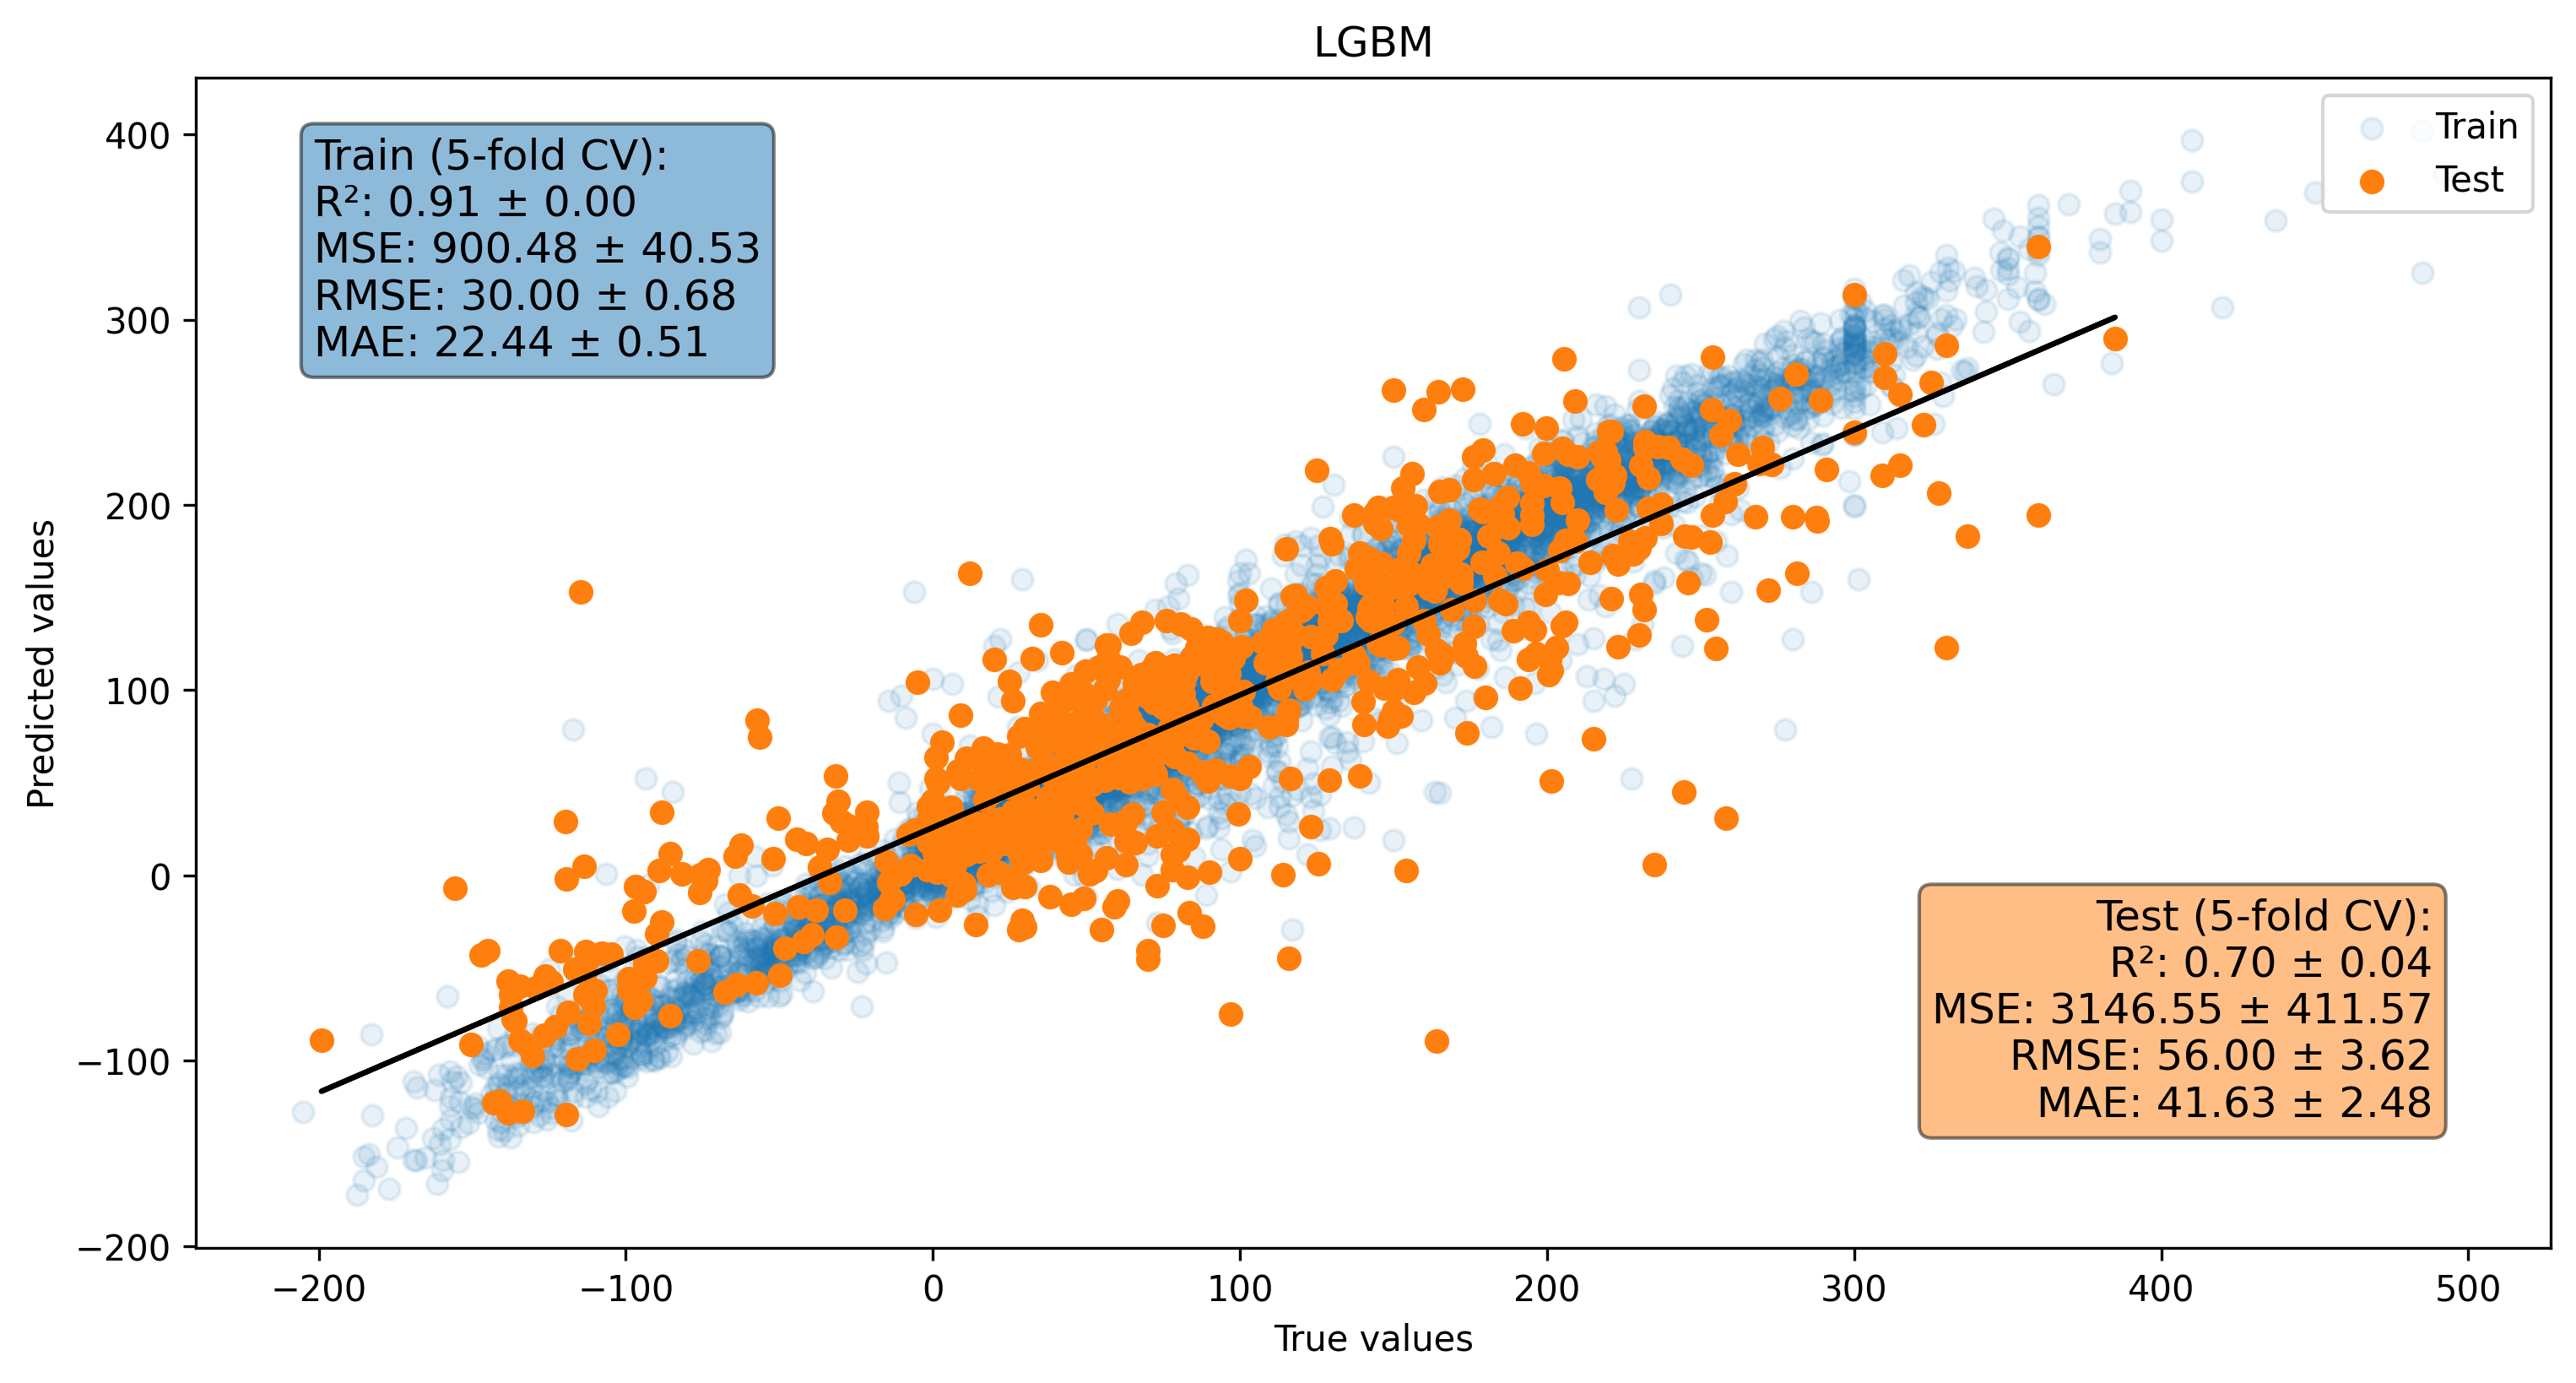

In [89]:
# plot the test and train data with scatter plot
# the fitted line is also plotted
# take rmse, r2, mae, mse from the results and plot them in the title (take it from cv_scores)

# get the data
y_true_test = data["test"]["y_true"]
y_pred_test = data["test"]["y_pred"]
y_linear_fit_test = data["test"]["y_linear_fit"]

y_true_train = data["train"]["y_true"]
y_pred_train = data["train"]["y_pred"]
y_linear_fit_train = data["train"]["y_linear_fit"]


metrics = ["r2", "mse", "rmse", "mae"]
test_scores = {}
train_scores = {}

for v in ["test", "train"]:
    for k in metrics:
        mean = results["cv_scores"][v][k]["mean"]
        std = results["cv_scores"][v][k]["std"]
        if v == "test":
            test_scores[k] = f"{mean:.2f} ± {std:.2f}"
        else:
            train_scores[k] = f"{mean:.2f} ± {std:.2f}"


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
ax.scatter(y_true_test, y_pred_test, color="C1", label="Test")
ax.plot(y_true_test, y_linear_fit_test, color="k")
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.legend(loc='upper right')

# Add text annotations for metrics
textstr_train = "\n".join(
    (
        f"Train ({results['cv_fold']}-fold CV):",
        f'R²: {train_scores["r2"]}',
        f'MSE: {train_scores["mse"]}',
        f'RMSE: {train_scores["rmse"]}',
        f'MAE: {train_scores["mae"]}',
    )
)

textstr_test = "\n".join(
    (
        f"Test ({results['cv_fold']}-fold CV):",
        f'R²: {test_scores["r2"]}',
        f'MSE: {test_scores["mse"]}',
        f'RMSE: {test_scores["rmse"]}',
        f'MAE: {test_scores["mae"]}',
    )
)

ax.text(
    0.05,
    0.95,
    textstr_train,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="C0", alpha=0.5),
)
ax.text(
    0.95,
    0.30,
    textstr_test,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="C1", alpha=0.5),
)

ax.set_title(model.upper())
fig.set_dpi(300)
plt.show()

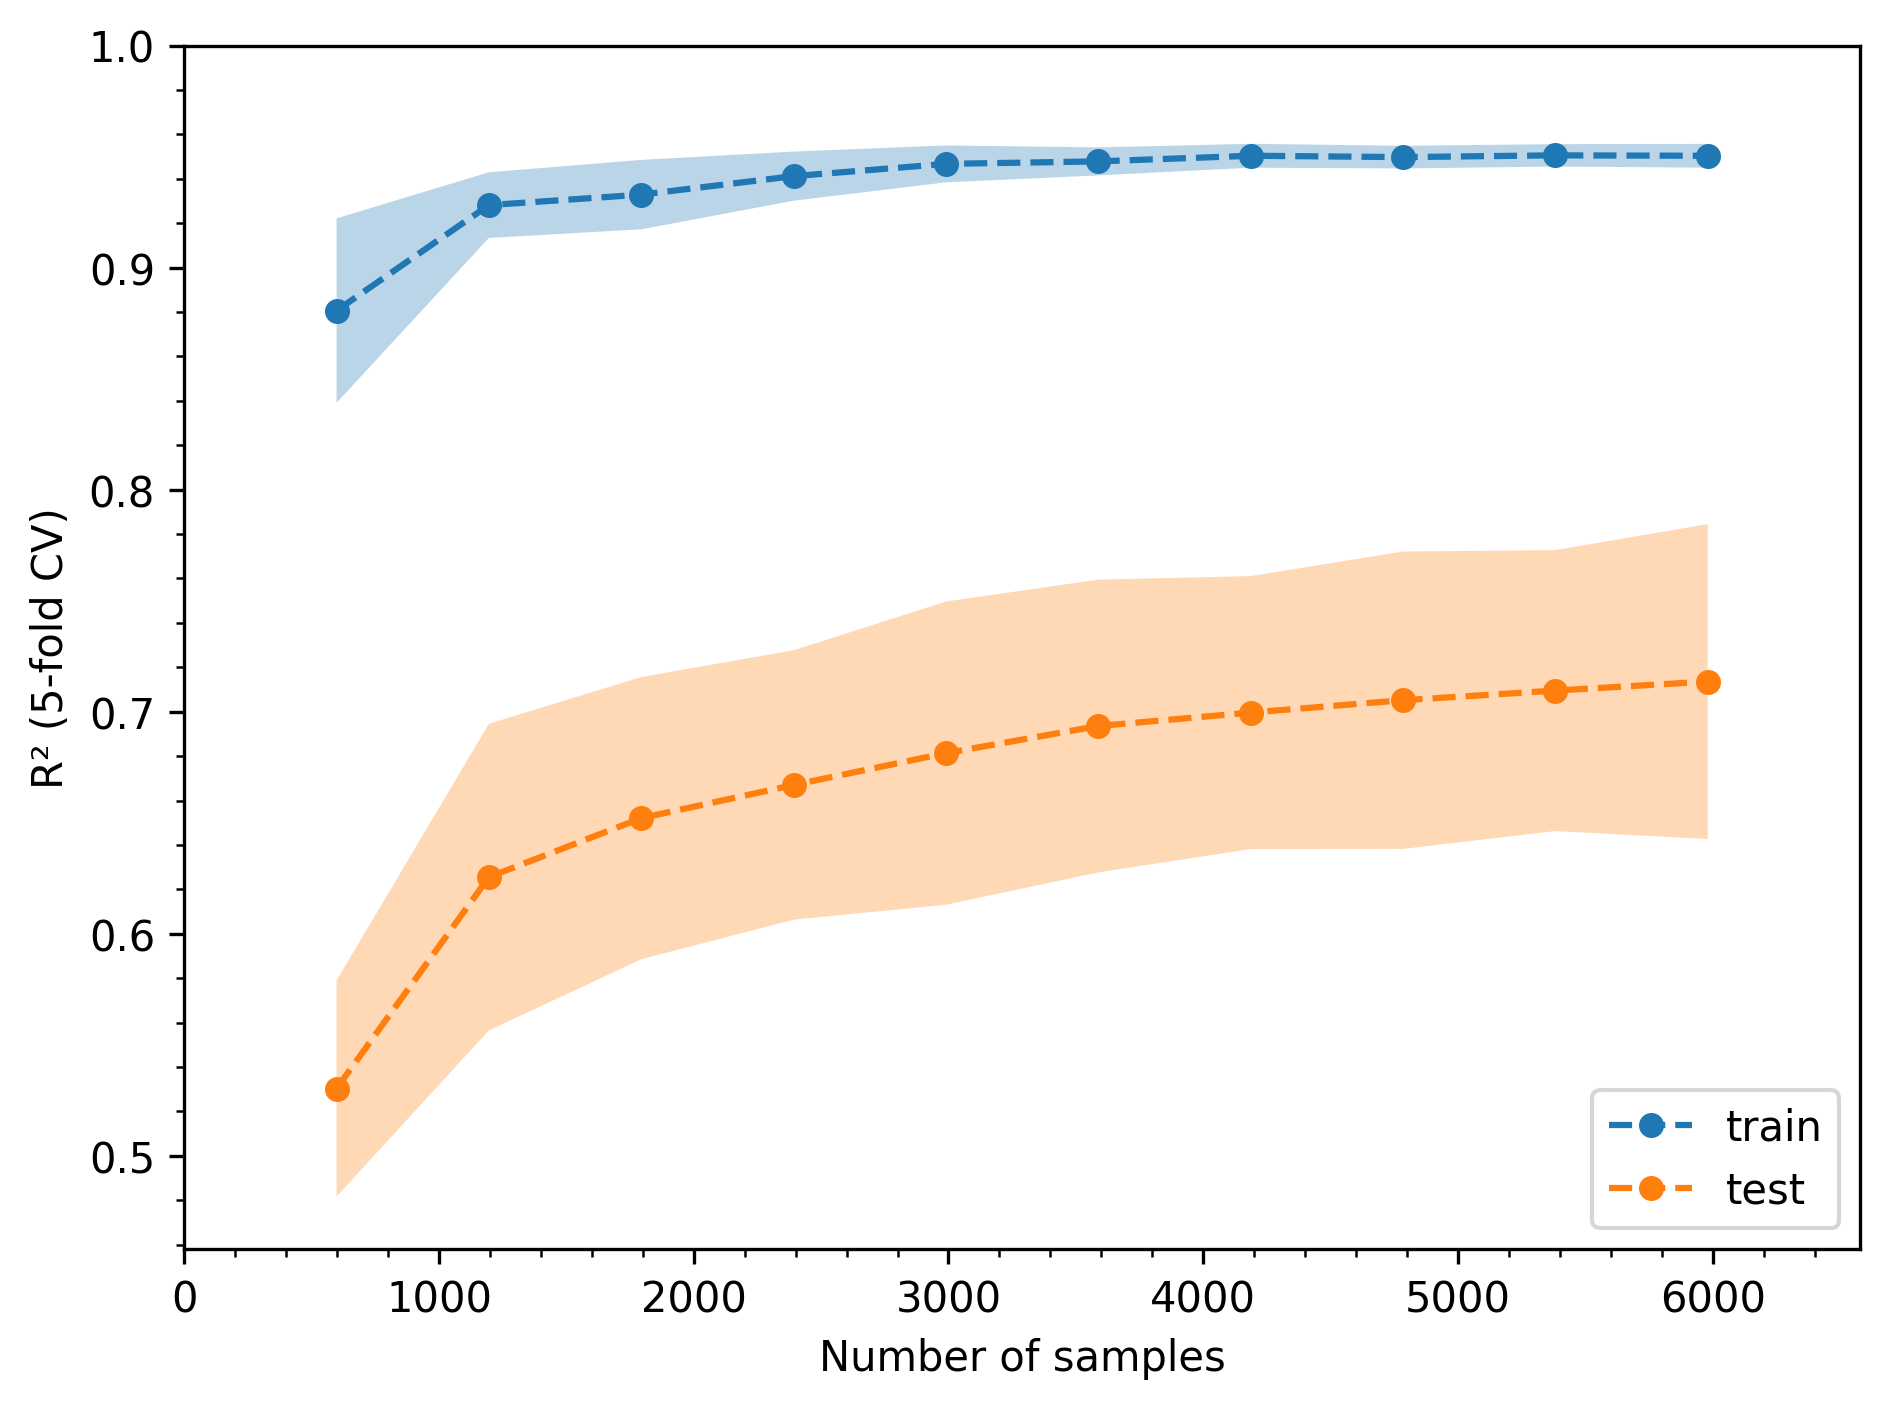

In [224]:
LearningCurveData = Dict[str, Dict[Literal["test", "train"], CVScores]]


class LearningCurve(TypedDict):
    data: LearningCurveData
    train_sizes: List[float]
    sizes: Tuple[float, float, int]
    CV: int
    scoring: Literal["r2"]

learning_curve_file = loc / f'{pre_trained_filename}.learning_curve.json'
learning_curve_json: LearningCurve = json.load(open(learning_curve_file, 'r'))
learning_curve_data = learning_curve_json["data"]

# with plt.style.context("seaborn-v0_8-dark"):
    # plot the learning curve
fig, ax = plt.subplots(dpi=300)
train_sizes = learning_curve_json["train_sizes"]

for t in ["train", "test"]:
    scores = [learning_curve_data[f"{size}"][t]["mean"] for size in train_sizes]
    ci_lower = [learning_curve_data[f"{size}"][t]["ci_lower"] for size in train_sizes]
    ci_upper = [learning_curve_data[f"{size}"][t]["ci_upper"] for size in train_sizes]
    
    ax.plot(train_sizes, scores, '.--', label=t, color="C0" if t == "train" else "C1", ms=10)
    ax.fill_between(train_sizes, ci_lower, ci_upper, alpha=0.3)
    
ax.set_xlabel("Number of samples")
ax.set_ylabel(f"R² ({learning_curve_json['CV']}-fold CV)")
ax.minorticks_on()
ax.legend()
ax.set_xbound(0, 1.1 * max(train_sizes))
ax.set_ylim(ymax=1)
fig.tight_layout()
fig.savefig(loc / f'{pre_trained_filename}.learning_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import joblib
import shap
shap.initjs()

estimator_file = loc / f'{pre_trained_filename}.pkl'
estimator_file.exists()
estimator, _ = joblib.load(estimator_file)
estimator

LGBMRegressor(n_jobs=8)

In [31]:
processed_vec_dir = main_loc / f'embedded_vectors/processed_{embeddings}/'
# list(processed_vec_dir.glob('*.npy'))
X = np.load(processed_vec_dir / 'processed.X.npy', allow_pickle=True)
y = np.load(processed_vec_dir / 'processed.y.npy', allow_pickle=True)
X.shape, y.shape

((7476, 300), (7476,))

In [35]:
# 1. Correlation Matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(pd.DataFrame(X).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
# plt.title('Correlation Matrix of Molecular Descriptors')
# plt.tight_layout()
# plt.savefig('correlation_matrix.png')
plt.close()

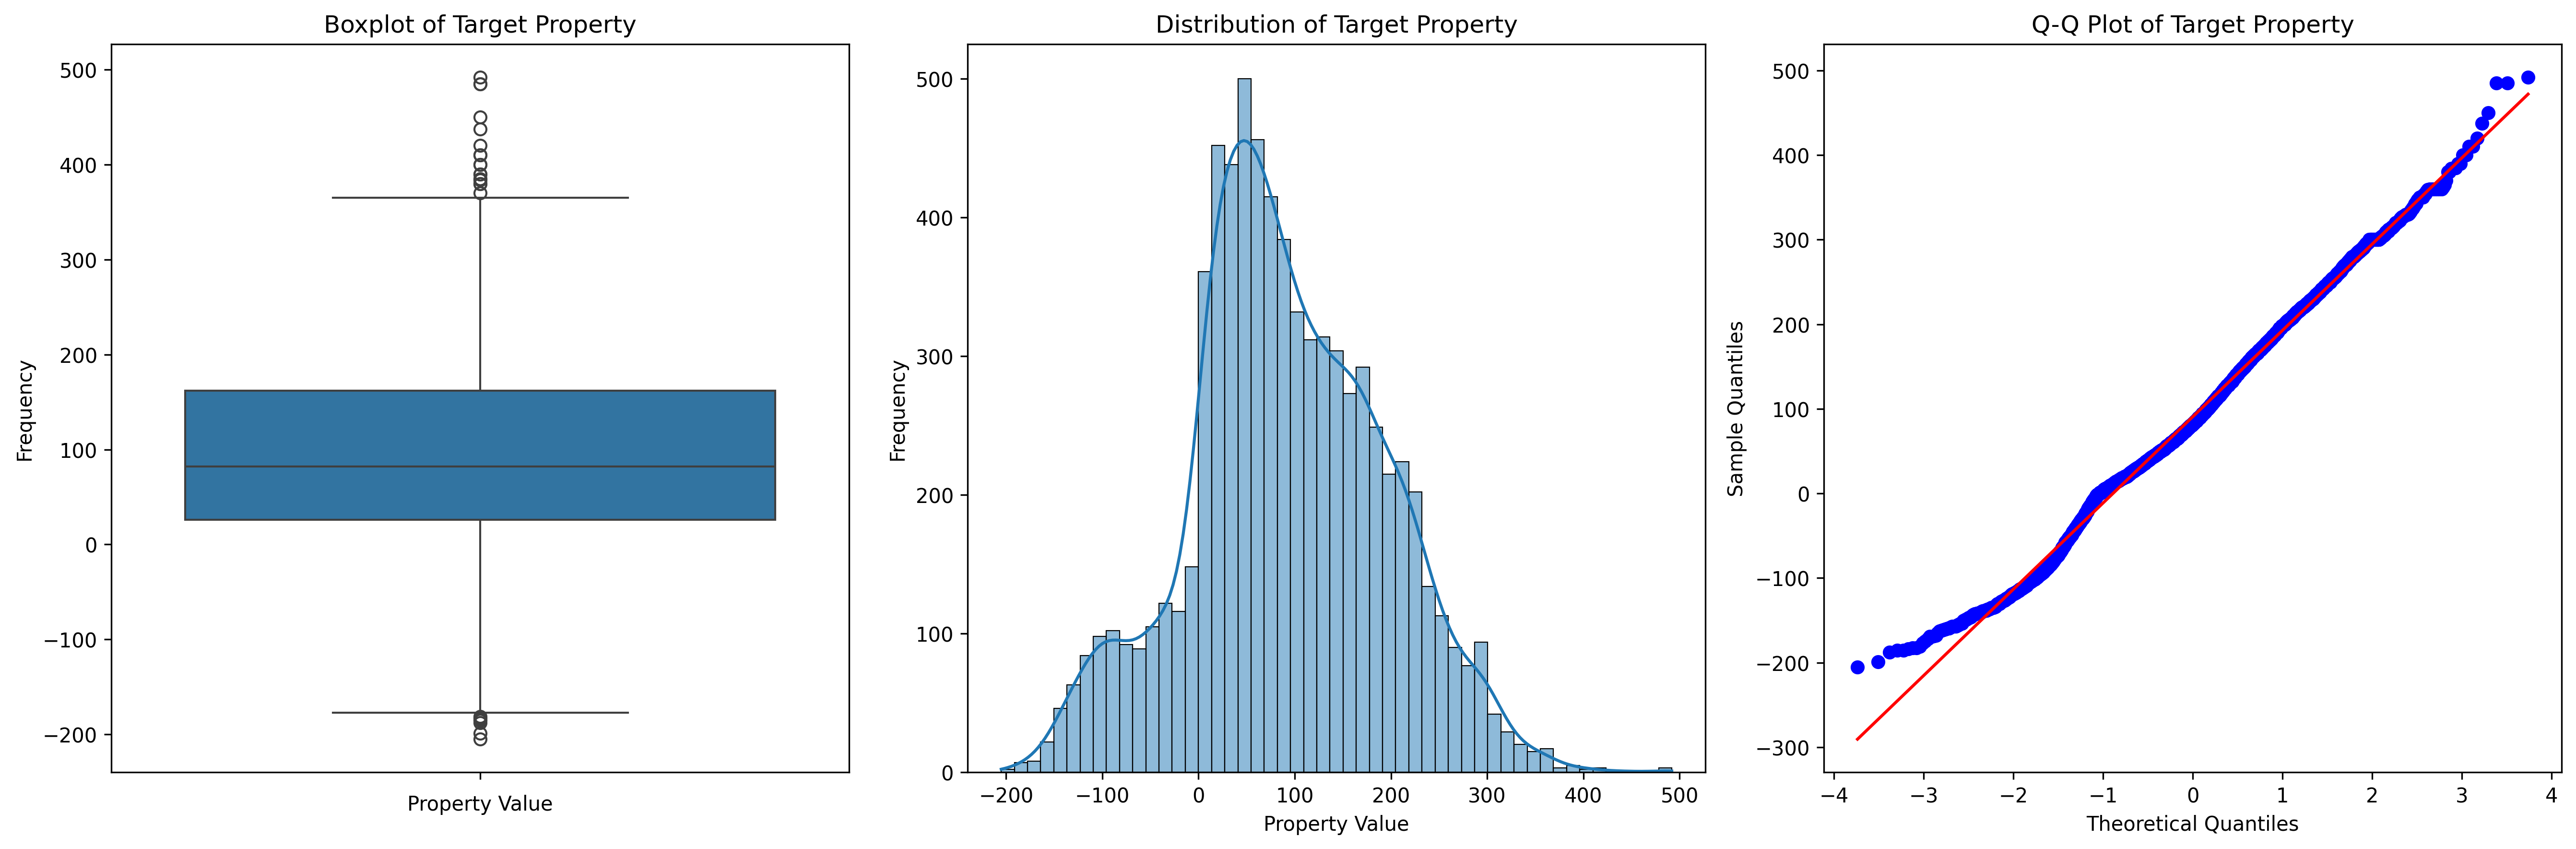

In [61]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

# Boxplot on the first subplot
sns.boxplot(y, ax=axes[0])
axes[0].set_title('Boxplot of Target Property')
axes[0].set_xlabel('Property Value')
axes[0].set_ylabel('Frequency')

# Histogram with KDE on the second subplot
sns.histplot(y, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Target Property')
axes[1].set_xlabel('Property Value')
axes[1].set_ylabel('Frequency')

# Q-Q plot on the third subplot
stats.probplot(y, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Target Property')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Sample Quantiles')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# 3. Actual vs. Predicted Plot
# y_pred = estimator.predict(X)
# plt.figure(figsize=(10, 6))
# plt.scatter(y, y_pred, alpha=0.5)
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Plot')
# plt.tight_layout()
# plt.savefig('actual_vs_predicted.png')
# plt.close()

In [41]:
# 5. Feature Importance Plot
# importances = estimator.feature_importances_
# indices = np.argsort(importances)[::-1]
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(X.shape[1]), importances[indices])
# plt.xticks(range(X.shape[1]), indices)
# plt.xlabel('Feature Index')
# plt.ylabel('Importance')
# plt.tight_layout()
# plt.savefig('feature_importance.png')
# plt.close()

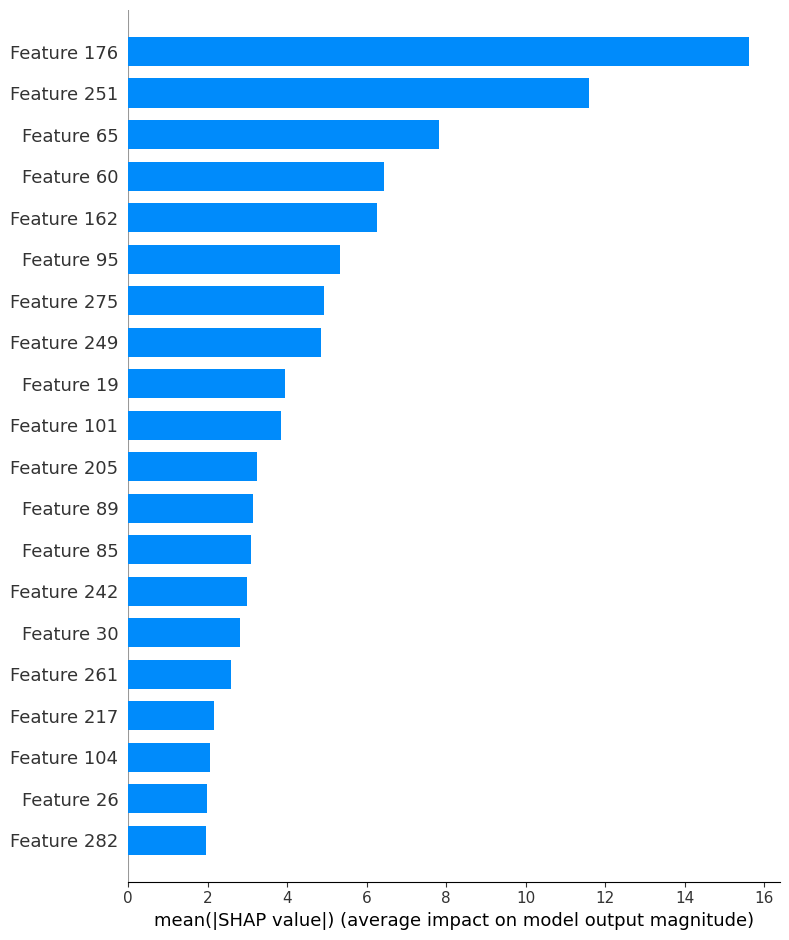

In [45]:
# 7. SHAP Summary Plot
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
# shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
# plt.savefig('shap_summary.png')
# plt.close()

In [29]:
shapely_file = loc / f'{pre_trained_filename}.shapley.json'
print(shapely_file.exists())
shapely_values = json.load(open(shapely_file, 'r'))
shap_values = np.array(shapely_values["shap_values"])

# data = {
#         "feature_names": explainer.feature_names or feature_names,
#         "shap_values": shap_values_array.tolist(),
#         "mean_abs_shap": mean_abs_shap.tolist(),
#     }

True


In [9]:
explainer = shap.TreeExplainer(estimator, X)
shap_values = explainer(X, check_additivity=False)

 98%|===================| 6598/6728 [00:20<00:00]        

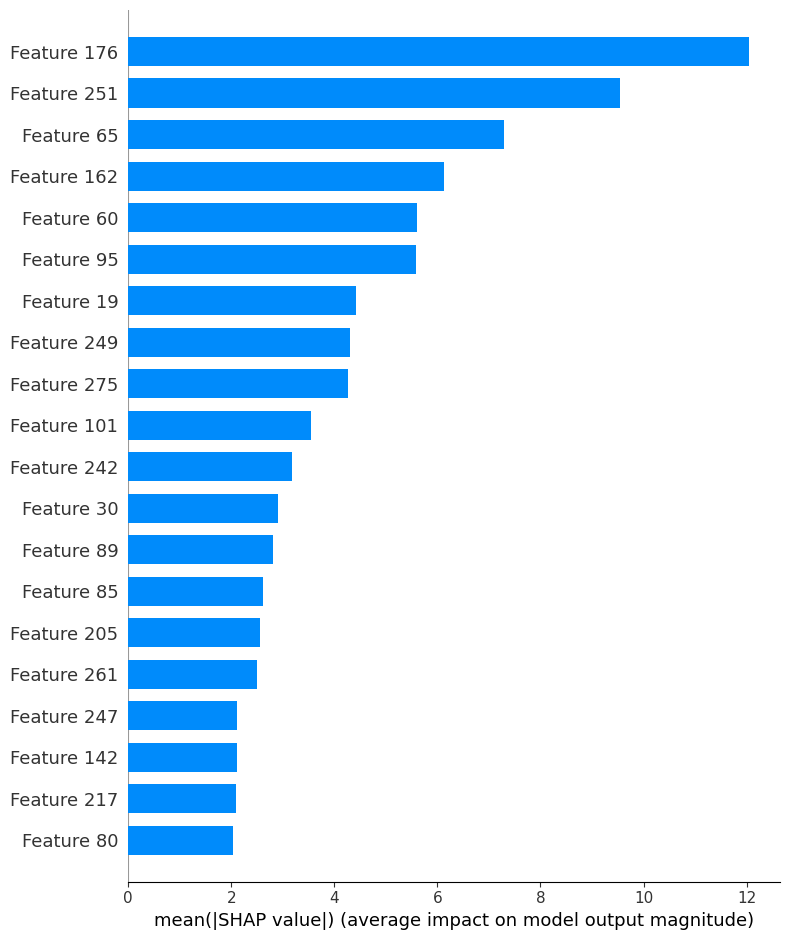

In [10]:
shap.summary_plot(shap_values, X, feature_names=shapely_values["feature_names"], plot_type="bar")

In [15]:
n_samples = 100  # Adjust this number as needed
if len(shap_values) > n_samples:
    indices = np.random.choice(len(shap_values), n_samples, replace=False)
    shap_values_subsampled = shap_values[indices]
else:
    shap_values_subsampled = shap_values
    
shap.plots.force(shap_values_subsampled)

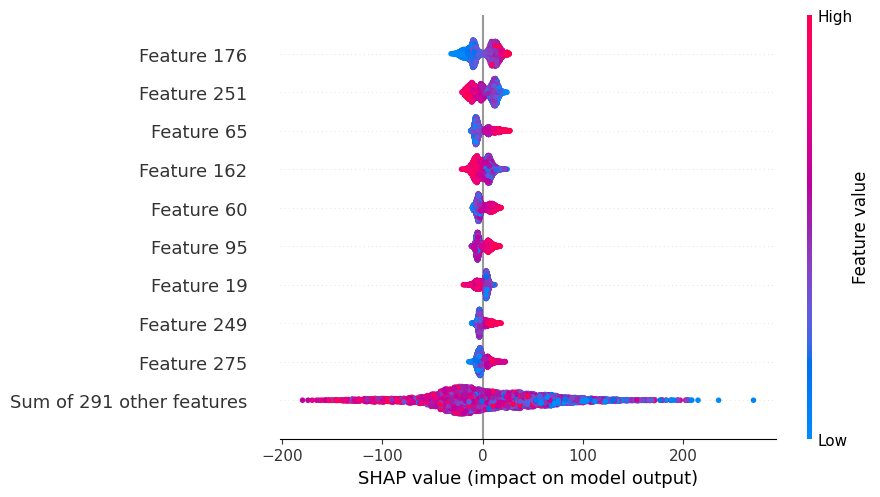

In [16]:
shap.plots.beeswarm(shap_values)


In [53]:
import numpy as np
import os
import h5py
import time

# Create a sample NumPy vector
vector = np.random.rand(1000000)  # 1 million random float values

# Method 1: Using numpy.savez_compressed
def save_with_npz(vector, filename):
    np.savez_compressed(filename, data=vector)

# Method 2: Using numpy.save with compression
def save_with_np_compression(vector, filename):
    np.save(filename, vector, allow_pickle=False, fix_imports=False)

# Method 3: Using HDF5 via h5py
def save_with_h5py(vector, filename, compression="gzip", compression_opts=None):
    with h5py.File(filename, 'w') as f:
        if compression == "lzf":
            f.create_dataset('data', data=vector, compression=compression)
        elif compression == "gzip":
            f.create_dataset('data', data=vector, compression=compression, 
                             compression_opts=compression_opts if compression_opts is not None else 9)
        else:
            f.create_dataset('data', data=vector)

# Function to measure file size
def get_file_size(filename):
    return os.path.getsize(filename) / (1024 * 1024)  # Size in MB

# Test and compare methods
methods = [
    ("npz", save_with_npz, "vector_compressed.npz"),
    ("np_compression", save_with_np_compression, "vector_compressed.npy"),
    ("h5py_gzip", lambda v, f: save_with_h5py(v, f, "gzip", 9), "vector_compressed_gzip.h5"),
    ("h5py_lzf", lambda v, f: save_with_h5py(v, f, "lzf"), "vector_compressed_lzf.h5"),
    ("h5py_no_compression", lambda v, f: save_with_h5py(v, f, None), "vector_uncompressed.h5")
]

print("Original vector size in memory: {:.2f} MB".format(vector.nbytes / (1024 * 1024)))

best_method = None
faster_method = None
for method_name, save_func, filename in methods:
    start_time = time.time()
    save_func(vector, filename)
    end_time = time.time()
    file_size = get_file_size(filename)
    best_method = (method_name, file_size) if best_method is None or file_size < best_method[1] else best_method
    faster_method = (method_name, end_time - start_time) if faster_method is None or end_time - start_time < faster_method[1] else faster_method
    print(f"{method_name}:")
    print(f"  Compressed file size: {file_size:.2f} MB")
    print(f"  Compression time: {end_time - start_time:.4f} seconds")

    # Verify data integrity by loading and comparing
    if method_name.startswith("h5py"):
        with h5py.File(filename, 'r') as f:
            loaded_vector = f['data'][:]
    elif method_name == "npz":
        loaded_vector = np.load(filename)['data']
    else:
        loaded_vector = np.load(filename)
    
    print(f"  Data integrity check: {np.allclose(vector, loaded_vector)}")
    print()
    
    # clean up
    # os.remove(filename)

print(f"Best method: {best_method[0]} with a file size of {best_method[1]:.2f} MB")
print(f"Faster method: {faster_method[0]} with a time of {faster_method[1]:.4f} seconds")

# Clean up files
# for _, _, filename in methods:
#     os.remove(filename)


Original vector size in memory: 381.47 MB
npz:
  Compressed file size: 359.73 MB
  Compression time: 11.1161 seconds
  Data integrity check: True

np_compression:
  Compressed file size: 381.47 MB
  Compression time: 0.2238 seconds
  Data integrity check: True

h5py_gzip:
  Compressed file size: 359.92 MB
  Compression time: 17.7529 seconds
  Data integrity check: True

h5py_lzf:
  Compressed file size: 381.62 MB
  Compression time: 1.3052 seconds
  Data integrity check: True

h5py_no_compression:
  Compressed file size: 381.47 MB
  Compression time: 0.6457 seconds
  Data integrity check: True

Best method: npz with a file size of 359.73 MB
Faster method: np_compression with a time of 0.2238 seconds
